**Snow Cover Extent Change Northern Illinois**

This notebook imports landsat 8 data using google earth engine api, creates a mosaic of images from a chosen month, masks clouds, calculates NDSI, and creates a timeseries of snow extent for a select AOI.

In [ ]:
!pip install cartopy scipy

In [ ]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geemap
import pandas as pd
from geemap import cartoee
import os

In [ ]:
# initialize google earth engine
ee.Authenticate()
ee.Initialize(project='ee-snowcovernil')
geemap.ee_initialize()

In [ ]:
# # set aoi geometry

# # northern il
# # aoi = ee.Geometry.Rectangle([-90.5, 41.5, -87.5, 42.5])

# Set the Area of Interest (AOI) to Northern Illinois (can adjust for Illinois boundary)
aoi = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'Illinois'))

In [ ]:
# Define the date range for January for every year
start_year = 2014
end_year = 2025

In [ ]:
# Function to mask clouds based on the QA band
def mask_clouds(image):
    # Select the QA band
    qa = image.select('QA_PIXEL')

    # Bits 3 and 5 are cloud shadow and clouds, respectively
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 5).eq(0))

    # Return the masked image, scaled to reflectance values
    return image.updateMask(cloud_mask)

In [ ]:
# # Filter Landsat 8 Collection

# Function to mosaic images by year
def mosaic_by_year(year):
    # Filter the Landsat 8 Collection for January of the given year
    start_date = ee.Date.fromYMD(year, 3, 1)
    end_date = ee.Date.fromYMD(year, 4, 1)  # end of January

    # Filter the Landsat collection and apply cloud mask
    collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                  .filterBounds(aoi)
                  .filterDate(start_date, end_date)
                  .map(mask_clouds))

    # Check if the collection contains images
    if collection.size().getInfo() == 0:
        print(f"No images found for year {year}")
        return None

    # Mosaic the collection and clip to AOI
    mosaic = collection.mosaic().clip(aoi)
    return mosaic

In [ ]:
# # calculate NDSI

# Function to calculate NDSI
def calc_ndsi(image):
    ndsi = image.normalizedDifference(['SR_B3', 'SR_B6'])
    return ndsi

In [ ]:
# Function to calculate snow-covered area (snow area where NDSI > 0.4)
def calc_snow_area(ndsi_image):
    snow_mask = ndsi_image.gt(0.4)
    snow_area = snow_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=aoi, scale=30, maxPixels=1e9)

    # convert area from sq m to sq km
    snow_area_km2 = ee.Number(snow_area.get('nd')).divide(1e6)

    return snow_area_km2
    # return snow_area.get('nd')

In [ ]:
# Calculate total snow-covered area for each year (in square kilometers)

# Initialize lists to store the snow area for each year
years = list(range(start_year, end_year + 1))
snow_area_list = []

# Loop through each year, calculate the snow area, and store it
for year in years:
    # Mosaic images for the given year and calculate NDSI
    mosaic = mosaic_by_year(year)

    # Check if a mosaic was created, skip if None
    if mosaic is not None:
        ndsi = calc_ndsi(mosaic)
        # Calculate snow area for the given year
        snow_area = calc_snow_area(ndsi)
        snow_area_list.append(snow_area.getInfo())
    else:
        snow_area_list.append(None)

# Create a DataFrame to store the snow area and years
df = pd.DataFrame({'Year': years, 'Snow_Area_km2': snow_area_list})

# Print the snow area data for each year
print(df)

    Year  Snow_Area_km2
0   2014    2774.337665
1   2015     750.840373
2   2016      87.174284
3   2017    2687.384310
4   2018      19.169496
5   2019    2241.152325
6   2020      77.511193
7   2021    1164.908031
8   2022     387.261188
9   2023     240.302814
10  2024      56.391068
11  2025     518.677253


In [ ]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


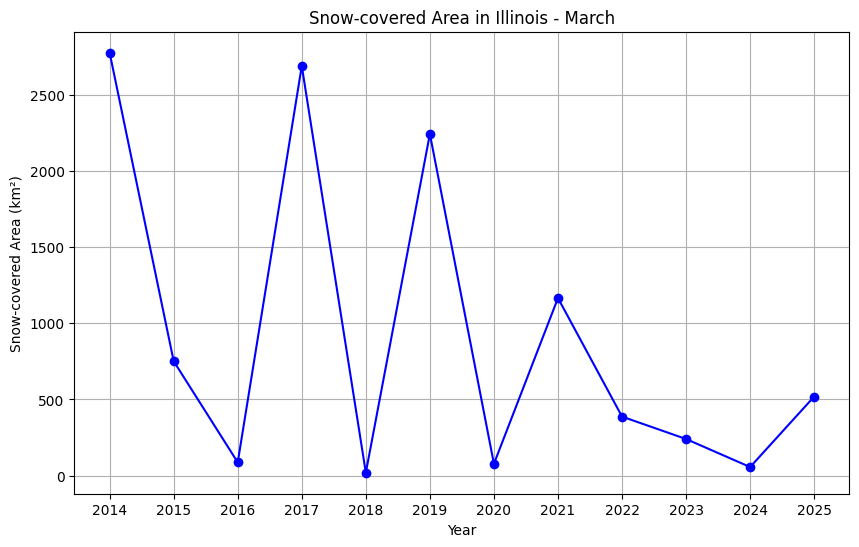

In [ ]:
# Plot the snow area time series
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Snow_Area_km2'], marker='o', color='b')
plt.xlabel('Year')
plt.ylabel('Snow-covered Area (km²)')
plt.title('Snow-covered Area in Illinois - March')
plt.xticks(range(start_year, end_year + 1))
plt.grid(True)

# Construct the full path to the folder in Google Drive
folder_path = '/content/drive/My Drive/GEE_Exports/'  # Replace with your folder name
file_name = 'snow_area_timeseries_mar.jpg'
full_path = os.path.join(folder_path, file_name)

plt.savefig(full_path)  # Save the plot to the specified path

plt.show()

In [ ]:
# Define the function to create the NDSI collection
def create_ndsi_collection2():
    # Load the Landsat 8 collection, apply cloud mask, and calculate NDSI
    collection2 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
                    .filterBounds(aoi) \
                    .map(mask_clouds) \
                    .map(calculate_ndsi2)
    return collection2

# Function to calculate NDSI (Normalized Difference Snow Index)
def calculate_ndsi2(image2):
    ndsi = image2.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')
    return image2.addBands(ndsi)

# def calculate_ndsi2(image2):
#     ndsi = image2.expression(
#         '(i.SR_B3 - i.SR_B6) / (i.SR_B3 + i.SR_B6)',  # NDSI formula
#         {'i': image2}
#     ).rename('NDSI')

#     # Handle NaN values by replacing them with a specific value (e.g., -1)
#     ndsi = ndsi.unmask(-1)

#     return image2.addBands(ndsi)

# Function to visualize a specific year's NDSI image
def show_annual_ndsi2(year):
    # Create the NDSI collection
    ndsi_collection2 = create_ndsi_collection2()

    # Filter the collection to the specified year and create a mosaic
    year_start = ee.Date(f'{year}-01-01')
    year_end = ee.Date(f'{year}-01-31')
    annual_ndsi_image2 = (ndsi_collection2.filterDate(year_start, year_end)
                         .select('NDSI')  # Select the NDSI band
                         .mosaic()
                         .clip(aoi))

    # Use geemap to display the NDSI image
    map = geemap.Map(basemap='HYBRID') #satellite basemap
    map.addLayer(annual_ndsi_image2, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'NDSI {year}')
    map.centerObject(aoi, 7)
    map.addLayerControl()

    # Add a colorbar to the map using geemap's built-in functionality
    # This replaces the cartoee.add_colorbar which is not compatible with geemap.Map
    map.add_colorbar(vis_params={'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']},
                     label="NDSI",
                     orientation="vertical",  # or "horizontal"
                     layer_name=f'NDSI {year}') # Matches the layer name for clarity

    # Return the map object to display it
    return map  # Remove map.show() and just return the map object

# Example: Show NDSI for 2018
show_annual_ndsi2(2025) # Call the function to display the map

Map(center=[40.100277314394525, -89.14995333122563], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# # Function to export NDSI images for multiple years to Google Drive
# def export_annual_ndsi_images(start_year, end_year, folder='GEE_Exports'):
#     for year in range(start_year, end_year + 1):
#         # Create the NDSI collection
#         ndsi_collection2 = create_ndsi_collection2()

#         # Filter the collection to the specified year and create a mosaic
#         year_start = ee.Date(f'{year}-01-01')
#         year_end = ee.Date(f'{year}-01-31')
#         annual_ndsi_image2 = (ndsi_collection2.filterDate(year_start, year_end)
#                              .select('NDSI')  # Select the NDSI band
#                              .mosaic()
#                              .clip(aoi))

#         # Export the image to Google Drive as JPG
#         task = ee.batch.Export.image.toDrive(
#             image=annual_ndsi_image2,
#             description=f'NDSI_{year}',  # Set the description/filename
#             scale=30,  # Adjust the scale as needed
#             region=aoi.geometry(),  # Set the region to your AOI
#             fileFormat='GeoTIFF',  # Change to your desired format if necessary
#             folder=folder  # Specify a folder in your Google Drive
#         )
#         task.start()
#         print(f'Exporting NDSI_{year} to Google Drive...')

# export_annual_ndsi_images(2014,2015) # Call the function to export images for multiple years

In [ ]:
# Get the area of Illinois in square kilometers
illinois_area = aoi.geometry().area().divide(1e6).getInfo()  # Convert to sq km

In [ ]:
# Calculate percentage snow cover for each year
df['Snow_Cover_Percentage'] = (df['Snow_Area_km2'] / illinois_area) * 100

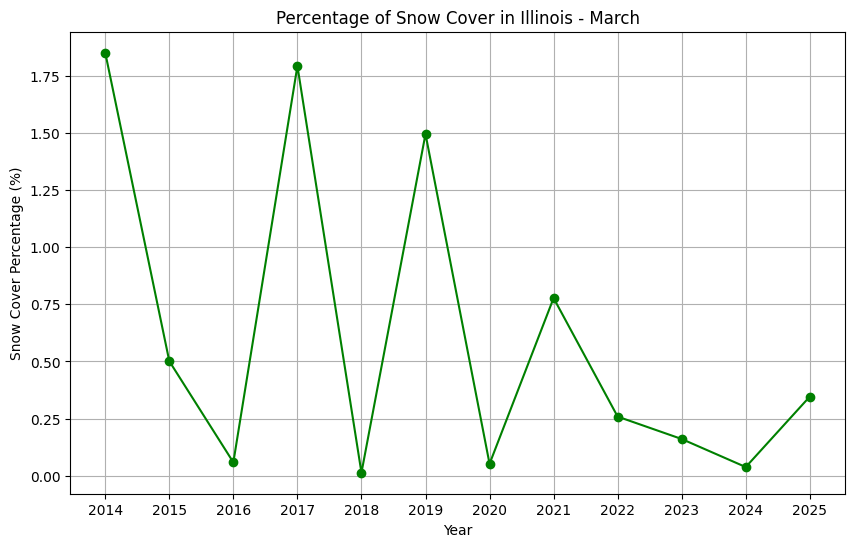

In [ ]:
# Plot the percentage snow cover time series
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Snow_Cover_Percentage'], marker='o', color='g') # Changed color to green
plt.xlabel('Year')
plt.ylabel('Snow Cover Percentage (%)')
plt.title('Percentage of Snow Cover in Illinois - March')
plt.xticks(range(start_year, end_year + 1))
plt.grid(True)

# Construct the full path for saving the plot
file_name = 'snow_cover_percentage_timeseries_mar.jpg'  # New filename
full_path = os.path.join(folder_path, file_name)

plt.savefig(full_path)
plt.show()